In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, 
    recall_score, precision_score, precision_recall_curve,
    classification_report, confusion_matrix, roc_curve
)
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 9)


In [55]:
df = pd.read_csv('final_dataset.csv')
ids = df['id'].copy()

# Drop unnecessary columns
drop_cols = ['id', 'application_id', 'referral_code', 'random_noise_1']
df = df.drop([col for col in drop_cols if col in df.columns], axis=1)

print(f"Loaded data shape: {df.shape}")
print(f"Default distribution: {Counter(df['default'])}")


Loaded data shape: (89999, 47)
Default distribution: Counter({0: 85405, 1: 4594})


In [56]:
categorical_cols = [
    'preferred_contact', 'account_status_code', 'loan_type', 'loan_purpose',
    'employment_type', 'education', 'marital_status'
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

print("✅ Categorical features encoded")


✅ Categorical features encoded


In [57]:
# Replace infinite values
df = df.replace([np.inf, -np.inf], np.nan)

# Fill missing values with median
df = df.fillna(df.median())

print(f"✅ Missing values handled")
print(f"Final dataset shape: {df.shape}")


✅ Missing values handled
Final dataset shape: (89999, 47)


In [58]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, ids, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Original train distribution: {Counter(y_train)}")
print(f"Imbalance ratio: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")


Train shape: (71999, 46)
Test shape: (18000, 46)
Original train distribution: Counter({0: 68324, 1: 3675})
Imbalance ratio: 18.6:1


In [59]:
print("⚖️ Resampling with SMOTETomek...")

smotetomek = SMOTETomek(
    smote=SMOTE(sampling_strategy=0.75, k_neighbors=5, random_state=42),
    random_state=42
)

X_train_bal, y_train_bal = smotetomek.fit_resample(X_train, y_train)

print(f"Balanced distribution: {Counter(y_train_bal)}")
print(f"New ratio: {(y_train_bal==0).sum()/(y_train_bal==1).sum():.2f}:1")


⚖️ Resampling with SMOTETomek...
Balanced distribution: Counter({0: 67580, 1: 50499})
New ratio: 1.34:1


In [60]:
print("🤖 Training CatBoost...")

scale_pos_weight = ((y_train_bal == 0).sum() / (y_train_bal == 1).sum()) * 2.5

catboost_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.02,
    depth=11,
    l2_leaf_reg=0.3,
    bagging_temperature=0.8,
    min_data_in_leaf=2,
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=False
)

catboost_model.fit(
    X_train_bal, y_train_bal,
    eval_set=(X_test, y_test),
    early_stopping_rounds=200,
    verbose=False
)

print("✅ CatBoost trained!")


🤖 Training CatBoost...
✅ CatBoost trained!


In [61]:
print("🤖 Training XGBoost...")

xgboost_model = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=9,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgboost_model.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("✅ XGBoost trained!")


🤖 Training XGBoost...
✅ XGBoost trained!


In [62]:
print("🎯 Creating ensemble...")

ensemble_model = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgboost', xgboost_model)
    ],
    voting='soft',
    weights=[2, 1]
)

ensemble_model.fit(X_train_bal, y_train_bal)

print("✅ Ensemble created!")


🎯 Creating ensemble...
✅ Ensemble created!


In [63]:
print("🔮 Generating predictions...")

# Get probabilities from all models
cat_proba = catboost_model.predict_proba(X_test)[:, 1]
xgb_proba = xgboost_model.predict_proba(X_test)[:, 1]
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Average probabilities
avg_proba = (cat_proba + xgb_proba + ensemble_proba) / 3

# Find best threshold
print("📊 Optimizing threshold...")
best_f1 = 0
best_threshold = 0.5

for threshold in np.arange(0.1, 0.7, 0.01):
    preds = (avg_proba >= threshold).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"✅ Best threshold: {best_threshold:.3f} (F1: {best_f1:.4f})")

# Final predictions
final_preds = (avg_proba >= best_threshold).astype(int)


🔮 Generating predictions...
📊 Optimizing threshold...
✅ Best threshold: 0.310 (F1: 0.2398)


In [64]:
print("="*80)
print("📊 FINAL RESULTS")
print("="*80)

print(f"AUC:       {roc_auc_score(y_test, avg_proba):.4f}")
print(f"F1 Score:  {f1_score(y_test, final_preds):.4f}")
print(f"Recall:    {recall_score(y_test, final_preds):.4f}")
print(f"Precision: {precision_score(y_test, final_preds):.4f}")
print(f"Accuracy:  {accuracy_score(y_test, final_preds):.4f}")
print(f"Threshold: {best_threshold:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, final_preds, target_names=['No Default', 'Default']))


📊 FINAL RESULTS
AUC:       0.7426
F1 Score:  0.2398
Recall:    0.3493
Precision: 0.1826
Accuracy:  0.8869
Threshold: 0.3100

📋 Classification Report:
              precision    recall  f1-score   support

  No Default       0.96      0.92      0.94     17081
     Default       0.18      0.35      0.24       919

    accuracy                           0.89     18000
   macro avg       0.57      0.63      0.59     18000
weighted avg       0.92      0.89      0.90     18000



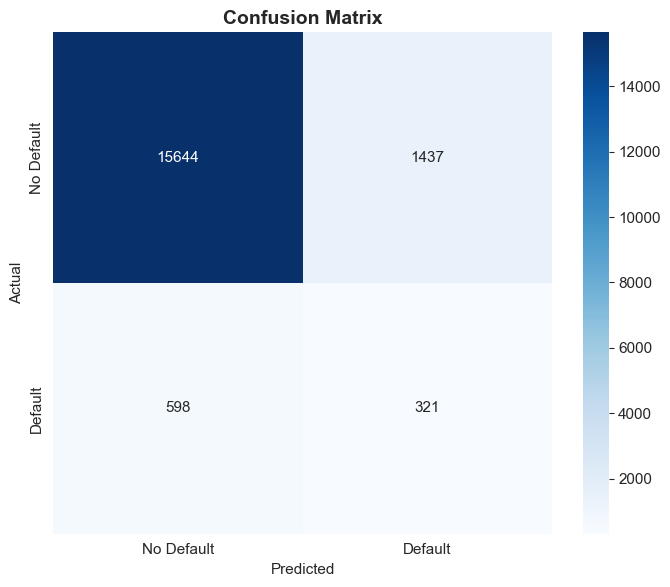

In [65]:
cm = confusion_matrix(y_test, final_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


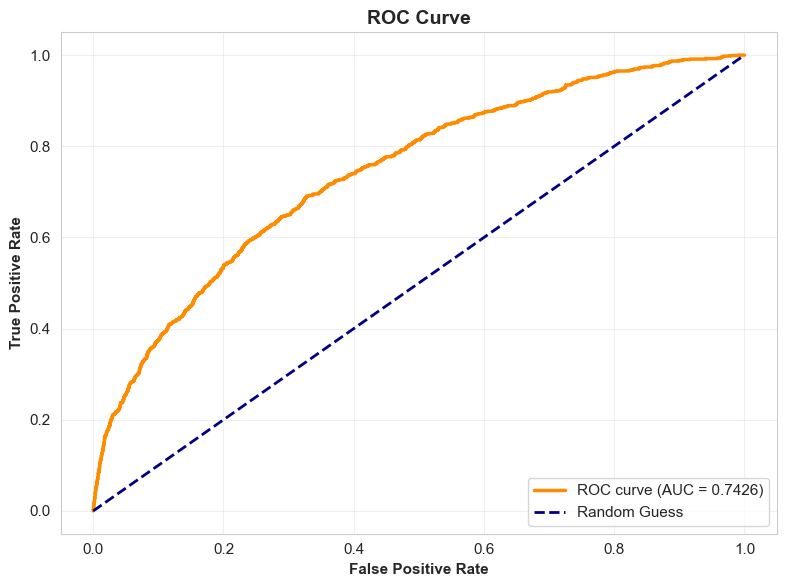

In [66]:
fpr, tpr, _ = roc_curve(y_test, avg_proba)
auc = roc_auc_score(y_test, avg_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve', fontweight='bold', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


🏆 TOP 10 MOST IMPORTANT FEATURES
               feature  importance
             loan_term   16.660208
          loan_purpose   14.179737
             loan_type    6.795878
   housing_price_index    5.132773
        monthly_income    3.623528
          credit_score    3.318675
num_delinquencies_2yrs    2.588878
             education    2.355892
     employment_length    1.912551
         annual_income    1.882689
✅ Saved: feature_importance_top20.png


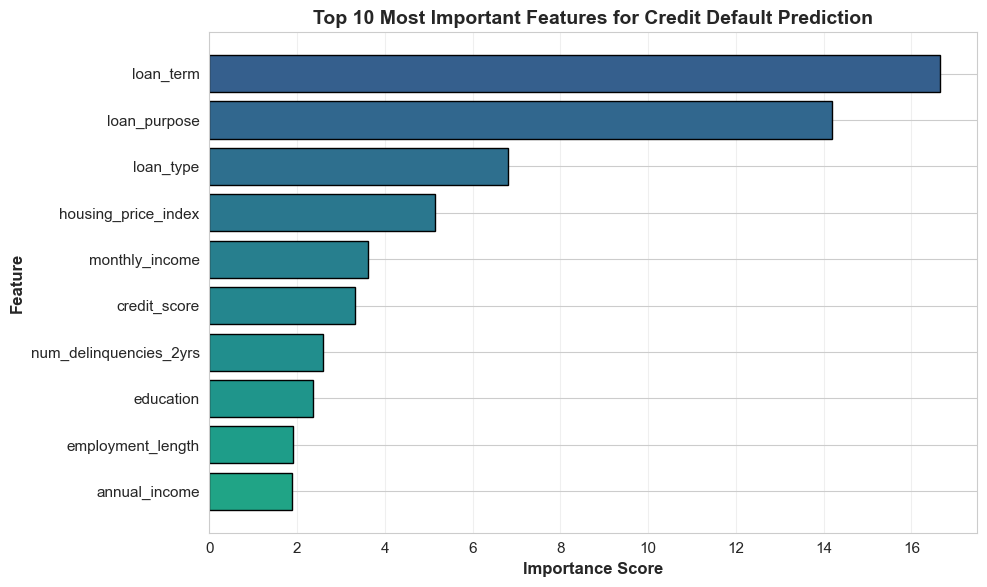

In [67]:
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': catboost_model.get_feature_importance()
}).sort_values('importance', ascending=False)
print("🏆 TOP 10 MOST IMPORTANT FEATURES")

top_10 = feature_importance_df.head(10)
print(top_10.to_string(index=False))
plt.figure(figsize=(10, 6))

top_10 = feature_importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 20))

plt.barh(top_10['feature'], top_10['importance'], color=colors, edgecolor='black')
plt.xlabel('Importance Score', fontweight='bold', fontsize=12)
plt.ylabel('Feature', fontweight='bold', fontsize=12)
plt.title('Top 10 Most Important Features for Credit Default Prediction', 
          fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_top20.png', dpi=300, bbox_inches='tight')
print("✅ Saved: feature_importance_top20.png")
plt.show()


In [68]:
submission = pd.DataFrame({
    'customer_id': id_test.values,     
    'prob': avg_proba,                 
    'default': final_preds             
})

submission.to_csv('submission.csv', index=False)

print(f"\n✅ Saved: submission.csv")
print(f"\n📊 File Details:")
print(f"   Format: customer_id, prob, default")
print(f"   Rows: {len(submission):,}")
print(f"   Columns: {len(submission.columns)}")
print(submission.head(20))


✅ Saved: submission.csv

📊 File Details:
   Format: customer_id, prob, default
   Rows: 18,000
   Columns: 3
    customer_id      prob  default
0         39219  0.151040        0
1         24222  0.002052        0
2         94117  0.012892        0
3         84252  0.049222        0
4         70072  0.036185        0
5         78411  0.003446        0
6         26617  0.013121        0
7         89410  0.188424        0
8         65867  0.019896        0
9         47814  0.362574        1
10        98700  0.055692        0
11        49741  0.011015        0
12        73752  0.006965        0
13        85094  0.098712        0
14        21862  0.001641        0
15        19943  0.012316        0
16        57365  0.127188        0
17        69651  0.038284        0
18        71366  0.058199        0
19        23978  0.000743        0
